The following additional libraries are needed to run this
notebook. Note that running on Colab is experimental, please report a Github
issue if you have any problem.

In [ ]:
!pip install git+https://github.com/d2l-ai/d2l-tvm
!pip install mxnet-cu100
!pip install https://tvm-repo.s3-us-west-2.amazonaws.com/tvm-0.7.dev1-cp37-cp37m-linux_x86_64.whl https://tvm-repo.s3-us-west-2.amazonaws.com/topi-0.7.dev1-py3-none-any.whl


# Matrix Multiplication

In this section, we will extend :numref:`ch_block_matmul_cpu` to optimize matrix multiplication on GPUs.

In [1]:
import d2ltvm
import numpy as np
import timeit
import tvm
from tvm import te

## Setup

We will use MXNet as our baseline, which calls cuBLAS to execute the matrix multiplication.

In [2]:
# Save to the d2ltvm package.
def matmul_timer_mxnet(n, ctx):
    """The matrix multiplication timer for MXNet

    n : width and height of inputs
    ctx : device
    """
    timer = timeit.Timer(
        setup='import d2ltvm\n'
        'import mxnet as mx\n'
        'a, b, c, = d2ltvm.get_abc((%d, %d), lambda x: mx.nd.array(x, ctx=mx.%s()))\n'
        'mx.nd.waitall()' % (n, n, ctx),
        stmt='mx.nd.dot(a, b, out=c); c.wait_to_read()')
    return timer.timeit

Then we compute its GFLOPS and plot the performance baseline as a function of matrix size.

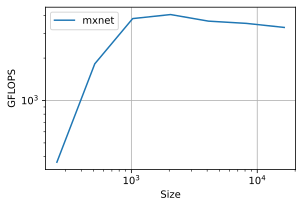

In [3]:
sizes = 2**np.arange(8, 15, 1)
exe_times = [d2ltvm.bench_workload(matmul_timer_mxnet(int(n), 'gpu'))
         for n in sizes]
mx_gflops = 2 * sizes ** 3 / 1e9 / np.array(exe_times)
d2ltvm.plot_gflops(sizes, [mx_gflops], ['mxnet'])

## Blocked Matrix Multiplication on GPU

We will follow :numref:`ch_block_matmul_cpu` to split the matrix $C$ into blocks, and have each core (streaming multiprocessor) to compute a block at a time. It can be done by assigning a block to a thread block as we did in :numref:`ch_vector_add_gpu` (don't confuse the matrix block with thread block here). As mentioned in :numref:`ch_gpu_arch`, the GPU core has a finer architecture, we need to split a block further for every CUDA thread in the thread block. The simplest 1-D case was already illustrated in :numref:`ch_vector_add_gpu`. This section will explore the local memory within a core using 2-D thread indexing.

### Shared Memory

Within a GPU core, there is a shared memory (or L1 cache) that can be accessed by all threads, which is managed by the compiler and hardware. Unlike CPU cache, we can allocate space directly on the shared memory just as the same as on the main memory and the global GPU memory.

In the TVM abstraction, we also call it cache to simplify the concept. The TVM scheduling primitive `cache_read` can create a read-only cache for $A$ that will be used by $C$ on the shared memory, i.e. `s.cache_read(A, "shared", [C])`.

![Blocked tiling for matrix multiplication with blocks denoted in blue on shared memory.](http://tvm.d2l.ai/_images/matmul_block_gpu1.svg)

:label:`fig_matmul_block_gpu_shared`


In :numref:`ch_block_matmul_cpu`, we created a write cache of an output block. Here, we will explore the opportunity to create read caches for input blocks. We redraw :numref:`fig_matmul_block` in :numref:`fig_matmul_block_gpu_shared`, it shows how to compute an output block through a series of matrix multiplications over input blocks. Since we will use all threads in a thread block to calculate this output block, we can cache input blocks in the shared memory. Now we can rewrite the block computation in  :numref:`ch_block_matmul_cpu` as:

```python
for k in range(0, n, tk):
    A_shared = A[y:y+ty, k:k+tk]  # cache in shared memory
    B_shared = B[k:k+tk, x:x+tx]  # cache in shared memory
    # use all threads in the thread block
    C[y:y+ty, x:x+tx] += dot(A_shared, B_shared)
```


Here `tx`, `ty` and `tk` are the tile sizes. The only difference is that we put the input blocks in the shared memory of a GPU core.

Assuming `tx=64`, `ty=128` and `tk=32`, then for each core, we will cache two matrices with sizes $128\times 32$ and $32\times 64$ on the shared memory, with a total size 24 KB. We can query the shared memory size per block in KB of the GPU we are using to make sure that these two matrices can fit into the shared memory. Note that this is different from the shared memory size per SM we reported in :numref"`ch_gpu_arch`.

In [4]:
ctx = tvm.gpu()
ctx.max_shared_memory_per_block/1024

48.0

### Thread Block and Registers

Next let's explore how to compute an output block using one GPU core in parallel efficiently. We can use the same idea: further splitting the output block into smaller block tiles, and having each thread to compute one tile. :numref:`fig_matmul_thread_block` shows splitting a $128 \times 64$ output block into 256 ($16 \times 16$) tiles, each of which is an $8\times 4$ matrix. Then we will create 256 threads within this thread block. Since the output is a matrix, we use a 2-D thread indexing, with `blockDim.x = blockDim.y = 16`. In addition, we will move the inputs, two vectors with lengths of 8 and 4, respectively, and the output, an $8\times 4$ matrix, for each thread into the registers.

![Further blocked tiling for matrix multiplication to put small tiles into registers.](http://tvm.d2l.ai/_images/matmul_thread_block.svg)

:label:`fig_matmul_thread_block`


Registers are local memory to a CUDA thread that is running. Accessing the registers are faster than the shared memory. So our goal is to make sure the data that we want to use each time can fit into the registers. In our case, each thread has three tensors with sizes $8\times 1$, $1\times 4$ and $8\times 4$, respectively. These lead to in total 46 32-bit floats. In the Tesla T4 GPU that we are using, each block has 65,536 32-bit registers shared by up to 1024 threads. Therefore, we can easily fit the data to the registers.

### Cooperative Fetching

Finally, loading the blocks of `A_shared` and `B_shared` into the shared memory is time consuming. We can accelerate it through multi-threading, namely using all threads in a thread block to load it.

## Implementation

We first implement utility methods which split an axis with a list of factors, and bind a list of axes with threads.

In [5]:
# Save into the d2ltvm package.
def split(stage, axis, factors):
    """Split an axis by a list of factors in a reverse order
    """
    axes = []
    for f in reversed(factors):
        axis, x = stage.split(axis, f)
        axes.append(x)
    return list(reversed(axes+[axis]))

# Save into the d2ltvm package.
def bind_thread(stage, axes, tags):
    """Bind a list of axes to thread axes
    """
    for axis, tag in zip(axes, tags):
        stage.bind(axis, te.thread_axis(tag))

Next we specify the hyperparameters with values we described before.

In [6]:
block_size = 16  # the number of threads for one dimension in a thread block.
tx, ty, tk = 8, 4, 32  # tile sizes for one CUDA thread

Now we can implement our schedule. There are three things worth mentioning: 

1. we denote by `x` the rows and `y` the columns, so an element can be assessed by `C[x,y]`.
2. As mentioned above, in CUDA thread indexing, `x` is used for the innermost dimension, which is the matrix column in our case. Therefore you will see we bind axis `yb` (split from `y`) to `blockIdx.x` instead of `blockIdx.y`. 
3. W need to partition the axes of `A_shared` and `B_shared` into `block_size` parts, so we can reuse the threads bound to `xo` and `yo` for cooperative fetching. Otherwise TVM may not properly synchronize threads which leads to wrong results.

In [7]:
def matmul_gpu(n):
    A, B, C = d2ltvm.matmul(n, n, n)
    s = te.create_schedule(C.op)
    # Create caches
    A_shared = s.cache_read(A, "shared", [C])
    A_local  = s.cache_read(A_shared, "local", [C])
    B_shared = s.cache_read(B, "shared", [C])
    B_local  = s.cache_read(B_shared, "local", [C])
    C_local = s.cache_write(C, "local")
    # Split each axis into block axis, thread axis, and inner axis
    x, y = s[C].op.axis
    xb, xo, xi = split(s[C], x, (block_size, tx))
    yb, yo, yi = split(s[C], y, (block_size, ty))
    s[C].reorder(xb, yb, xo, yo, xi, yi)
    # Note that we bind yb to blockIdx.x instead of blockIdx.y
    bind_thread(s[C], (yb, xb, yo, xo),
                ("blockIdx.x", "blockIdx.y", "threadIdx.x", "threadIdx.y"))
    # Schedule C_local
    s[C_local].compute_at(s[C], yo)
    yi, xi = s[C_local].op.axis
    k, = s[C_local].op.reduce_axis
    ko, ki = s[C_local].split(k, tk)
    s[C_local].reorder(ko, ki, yi, xi)
    # Optimize read caches of A and B with cooperative fetching
    def optimize_read_cache(shared, local):
        s[shared].compute_at(s[C_local], ko)
        s[local].compute_at(s[C_local], ki)
        y, x = s[shared].op.axis
        # Note that we must split into block_size parts to reuse
        # the previous axis threads
        yo, yi = s[shared].split(y, nparts=block_size)
        xo, xi = s[shared].split(x, nparts=block_size)
        s[shared].reorder(yo, xo, yi, xi)
        bind_thread(s[shared], (yo, xo), ("threadIdx.y", "threadIdx.x"))
    optimize_read_cache(A_shared, A_local)
    optimize_read_cache(B_shared, B_local)
    return s, (A, B, C)

Let's verify the correctness of the schedule. First we print the pseudo codes. Since we didn't unroll the loops, the pseudo codes are relative compact and we can check the allocated cache sizes and how each stage is computed.

In [8]:
n = 2048
s, args = matmul_gpu(n)
tvm.lower(s, args, simple_mode=True)

produce C {
  // attr [iter_var(blockIdx.y, , blockIdx.y)] thread_extent = 16
  // attr [C.local] storage_scope = "local"
  allocate C.local[float32 * 32]
  // attr [A.shared] storage_scope = "shared"
  allocate A.shared[float32 * 4096]
  // attr [B.shared] storage_scope = "shared"
  allocate B.shared[float32 * 2048]
  // attr [A.shared.local] storage_scope = "local"
  allocate A.shared.local[float32 * 8]
  // attr [B.shared.local] storage_scope = "local"
  allocate B.shared.local[float32 * 4]
  // attr [iter_var(blockIdx.x, , blockIdx.x)] thread_extent = 32
  // attr [iter_var(threadIdx.y, , threadIdx.y)] thread_extent = 16
  // attr [iter_var(threadIdx.x, , threadIdx.x)] thread_extent = 16
  produce C.local {
    for (x.c.init, 0, 8) {
      for (y.c.init, 0, 4) {
        C.local[((x.c.init*4) + y.c.init)] = 0f
      }
    }
    for (k.outer, 0, 64) {
      produce A.shared {
        // attr [iter_var(threadIdx.y, , threadIdx.y)] thread_extent = 16
        // attr [iter_var(threadIdx

Next we compare the results against NumPy results to check the correctness.

In [9]:
target, ctx = 'cuda', tvm.gpu()
mod = tvm.build(s, args, target)
a, b, c, = d2ltvm.get_abc((n, n), lambda x: tvm.nd.array(x, ctx=ctx))
mod(a, b, c)
np.testing.assert_allclose(
    c.asnumpy(), np.dot(a.asnumpy(), b.asnumpy()), atol=1e-2)

Finally, we measure the performance to compare with our baseline. You can see that our schedule works well for small matrices but is constantly slower for large ones. The reason might due to 1) we didn't consider bank conflict when reading share memory; 2) there's other optimization opportunity that we didn't investigate; 3) previous works show that pure assembly codes, which cuBLAS uses, provide more room to optimize and often outperform CUDA codes :cite:`Nath.Tomov.Dongarra.2010,Lai.Seznec.2013`.

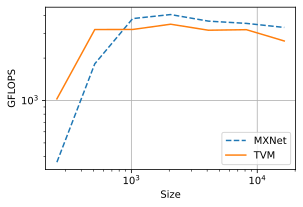

In [10]:
tvm_gflops = d2ltvm.bench_matmul_tvm(matmul_gpu, sizes, 'cuda')
d2ltvm.plot_gflops(sizes, [mx_gflops, tvm_gflops], legend=['MXNet', 'TVM'])

## Summary

- We use a two-level block tiling to parallelize matrix multiplication on GPUs.
- We load data used by a thread block into share memory, and data used by a CUDA thread into registers.
- The shared data within a thread block is loaded by cooperative fetching.